In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
import os

from pandas.plotting import parallel_coordinates
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.base import BaseEstimator
from sklearn.base import clone

from sklearn.model_selection import (
    StratifiedKFold, 
    ParameterGrid, 
    cross_validate,
    train_test_split
    )

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
try:
    import umap
except ImportError:
    !pip install umap-learn
    import umap


from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
)

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Librerías importadas correctamente")
print(f"Versión de scikit-learn: {__import__('sklearn').__version__}")

Librerías importadas correctamente
Versión de scikit-learn: 1.7.2


In [8]:
df = pd.read_csv('../data/processed/diabetes_sample.csv')
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0.0,0.0,1.0,42.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,3.0,4.0,2.0
1,0.0,0.0,0.0,1.0,19.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,30.0,0.0,0.0,0.0,7.0,5.0,8.0
2,0.0,0.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,6.0,8.0
3,0.0,0.0,0.0,1.0,31.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
4,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,6.0,8.0


In [9]:
target_col =  'Diabetes_012'
X = df.drop(columns=[target_col])
y = df[target_col]


print("Variables separadas:")
print(f"   X: {X.shape} → {X.shape[1]} features")
print(f"   y: {y.shape} → {y.nunique()} clases")
print(f"Features:")
for i, col in enumerate(X.columns, 1):
    print(f"   {i:2d}. {col}")

Variables separadas:
   X: (38052, 21) → 21 features
   y: (38052,) → 3 clases
Features:
    1. HighBP
    2. HighChol
    3. CholCheck
    4. BMI
    5. Smoker
    6. Stroke
    7. HeartDiseaseorAttack
    8. PhysActivity
    9. Fruits
   10. Veggies
   11. HvyAlcoholConsump
   12. AnyHealthcare
   13. NoDocbcCost
   14. GenHlth
   15. MentHlth
   16. PhysHlth
   17. DiffWalk
   18. Sex
   19. Age
   20. Education
   21. Income


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Datos divididos en entrenamiento y prueba:")
print(f"   X_train: {X_train.shape[0]} samples")   
print(f"   X_test : {X_test.shape[0]} samples")
print(f"   y_train: {y_train.shape[0]} samples")
print(f"   y_test : {y_test.shape[0]} samples")

Datos divididos en entrenamiento y prueba:
   X_train: 30441 samples
   X_test : 7611 samples
   y_train: 30441 samples
   y_test : 7611 samples


# BalancedDecisionForest: Clase auxiliar para el desarrollo del Arbol

In [11]:
class BalancedDecisionForest(BaseEstimator): # <--- HEREDAR DE BaseEstimator
    """
    Implementación de un Ensamble de Árboles de Decisión Balanceados.
    """
    def __init__(self, n_estimators=50, base_estimator=None):
        # NOTA: Los parámetros DEBEN ser guardados como atributos en __init__
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator
        self.models = [] 
        self.classes_ = None
        
        # Asignar un base_estimator por defecto si no se proporciona
        if self.base_estimator is None:
             self.base_estimator = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42)

    def fit(self, X, y):
        """
        Entrena el ensamble creando n_estimators subconjuntos balanceados.
        """
        self.models = []
        # Aseguramos que X sea un DataFrame para un manejo fácil de índices si viene de un array
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, index=range(len(X)))
            
        # Aseguramos que y sea una Serie para un manejo fácil de índices
        if not isinstance(y, pd.Series):
            y = pd.Series(y, index=X.index)
        
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        
        # 1. Identificar el tamaño de la clase minoritaria (N)
        class_counts = y.value_counts()
        N = class_counts.min() 
        
        # 2. Separar los índices de los datos por clase
        data_by_index = y.index.to_series().groupby(y).apply(list).to_dict()
        
        # 3. Entrenar n_estimators árboles
        for _ in range(self.n_estimators):
            balanced_indices = []
            
            for c in self.classes_:
                # Muestreo aleatorio de tamaño N de los índices de la clase
                indices_sampled = resample(
                    data_by_index[c], 
                    replace=True, 
                    n_samples=N, 
                    random_state=np.random.randint(0, 10000)
                )
                balanced_indices.extend(indices_sampled)
            
            # Subconjunto balanceado
            X_tree = X.loc[balanced_indices]
            y_tree = y.loc[balanced_indices]
            
            # Clonar el estimador base para asegurar que cada árbol es independiente
            tree = clone(self.base_estimator)
            tree.fit(X_tree, y_tree)
            self.models.append(tree)
        
        return self

    # Métodos predict y predict_proba (no requieren cambios funcionales)
    def predict(self, X):
        all_tree_predictions = []
        for model in self.models:
            all_tree_predictions.append(model.predict(X))
        
        predictions_matrix = np.array(all_tree_predictions)
        final_predictions = np.apply_along_axis(
            lambda x: np.bincount(x.astype(int), minlength=len(self.classes_)).argmax(), 
            axis=0, 
            arr=predictions_matrix
        )
        return final_predictions

    def predict_proba(self, X):
        all_tree_predictions = []
        for model in self.models:
            all_tree_predictions.append(model.predict(X))
        
        predictions_matrix = np.array(all_tree_predictions)
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        proba_matrix = np.zeros((n_samples, n_classes))
        
        for i in range(n_samples):
            votes = predictions_matrix[:, i]
            vote_counts = np.bincount(votes.astype(int), minlength=n_classes)
            proba_matrix[i] = vote_counts / self.n_estimators
            
        return proba_matrix

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_list = []
param_grid_bf = {
    'max_depth': [3, 5, 7, 8],
    'min_samples_leaf': [20, 30, 50, 100],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [50, 100]
}

print(f"Iniciando búsqueda en grilla con {len(list(ParameterGrid(param_grid_bf)))} combinaciones...")
start_time = time.time()

for params in ParameterGrid(param_grid_bf):
    # a. Definir el Estimador Base
    base_tree = DecisionTreeClassifier(
        max_depth=params['max_depth'], 
        min_samples_leaf=params['min_samples_leaf'], 
        criterion=params['criterion'],
        random_state=42
    )
    
    # b. Crear el Modelo de Ensamble (con el parámetro n_estimators)
    # Ahora que hereda de BaseEstimator, ya es clonable.
    model = BalancedDecisionForest(
        n_estimators=params['n_estimators'], 
        base_estimator=base_tree
    )
    
    # c. Evaluación por Cross-Validation
    scores = cross_validate(
        model, 
        X_train, y_train, # Usar X_train y y_train (asume que están definidos)
        cv=skf, 
        scoring='balanced_accuracy', 
        return_train_score=True, 
        n_jobs=-1
    )

    # d. Almacenar resultados
    mean_test_score = scores['test_score'].mean()
    mean_train_score = scores['train_score'].mean()

    results_list.append({
        'params': params,
        'mean_test_score': mean_test_score,
        'mean_train_score': mean_train_score
    })

# ... (Resto del código para resultados) ...

end_time = time.time()
print(f"Tiempo total de búsqueda en grilla: {end_time - start_time:.2f} segundos.")

results_df = pd.DataFrame(results_list)
best_model_row = results_df.loc[results_df['mean_test_score'].idxmax()]

print("\n--- MEJOR MODELO ENCONTRADO ---")
print(f"Mejores Parámetros: {best_model_row['params']}")
print(f"Balanced Accuracy (CV Mean): {best_model_row['mean_test_score']:.4f}")
print(f"Gap (Train - Test): {best_model_row['mean_train_score'] - best_model_row['mean_test_score']:.4f}")

Iniciando búsqueda en grilla con 64 combinaciones...
Tiempo total de búsqueda en grilla: 89.32 segundos.

--- MEJOR MODELO ENCONTRADO ---
Mejores Parámetros: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 30, 'n_estimators': 50}
Balanced Accuracy (CV Mean): 0.5258
Gap (Train - Test): 0.0468


In [13]:
# 1. Definir los parámetros óptimos encontrados
params_optimos = {
    'criterion': 'gini', 
    'max_depth': 7, 
    'min_samples_leaf': 30
}

# 2. Instanciar el Estimador Base con los mejores parámetros
base_tree_final = DecisionTreeClassifier(
    **params_optimos,
    random_state=42
)

# 3. Instanciar el Ensamble Final
mejor_modelo_bf = BalancedDecisionForest(
    n_estimators=100, # Usamos el mejor n_estimators encontrado
    base_estimator=base_tree_final
)

print("Entrenando el modelo Balanced Decision Forest final en el set de entrenamiento completo...")
# Asegúrate de usar las variables X_train y y_train
mejor_modelo_bf.fit(X_train, y_train)

print("Entrenamiento final completado.")

Entrenando el modelo Balanced Decision Forest final en el set de entrenamiento completo...
Entrenamiento final completado.


In [14]:
# 4. Hacer Predicciones en el conjunto de prueba (X_test, y_test)
y_pred_test_bf = mejor_modelo_bf.predict(X_test)

# 5. Calcular la Balanced Accuracy en Test
ba_test_bf = balanced_accuracy_score(y_test, y_pred_test_bf)

# 6. Comparación Final y Reporte
print("\n--- COMPARACIÓN FINAL DE RENDIMIENTO ---")
print(f"Balanced Accuracy (CV Esperado): {0.5252:.4f}")
print(f"Balanced Accuracy (TEST Final):  {ba_test_bf:.4f}")

print("\n--- REPORTE DE CLASIFICACIÓN FINAL (TEST) ---")
target_names = ['No Diabetes', 'Pre-diabetes', 'Diabetes'] 
print(classification_report(y_test, y_pred_test_bf, target_names=target_names, digits=4))


--- COMPARACIÓN FINAL DE RENDIMIENTO ---
Balanced Accuracy (CV Esperado): 0.5252
Balanced Accuracy (TEST Final):  0.4813

--- REPORTE DE CLASIFICACIÓN FINAL (TEST) ---
              precision    recall  f1-score   support

 No Diabetes     0.9448    0.6357    0.7600      6412
Pre-diabetes     0.0217    0.2158    0.0395       139
    Diabetes     0.3276    0.5925    0.4219      1060

    accuracy                         0.6220      7611
   macro avg     0.4314    0.4813    0.4071      7611
weighted avg     0.8420    0.6220    0.6998      7611



In [15]:
params_optimos_bf = {
    'criterion': 'gini', 
    'max_depth': 7, 
    'min_samples_leaf': 30
}

# --- 2. Re-instanciar y entrenar el modelo final ---
base_tree_final_bf = DecisionTreeClassifier(**params_optimos_bf, random_state=42)
mejor_modelo_bf = BalancedDecisionForest(n_estimators=100, base_estimator=base_tree_final_bf)

# Entrenar el modelo en el conjunto completo de entrenamiento
mejor_modelo_bf.fit(X_train, y_train) 

# --- 3. Calcular BA en Train y Test ---
y_pred_train_bf = mejor_modelo_bf.predict(X_train)
ba_train_bf = balanced_accuracy_score(y_train, y_pred_train_bf)

y_pred_test_bf = mejor_modelo_bf.predict(X_test)
ba_test_bf = balanced_accuracy_score(y_test, y_pred_test_bf)

# --- 4. Usar el valor CV Mean obtenido de la optimización ---
# Este valor es fijo, resultado de su cross_validate.
ba_cv_bf = 0.5252 

# --- 5. Imprimir resultados consolidados ---
print("--- BALANCED DECISION FOREST ---")
print(f"BA en Train:           {ba_train_bf:.4f}")
print(f"BA en Validation (CV): {ba_cv_bf:.4f}")
print(f"BA en Test:            {ba_test_bf:.4f}")

--- BALANCED DECISION FOREST ---
BA en Train:           0.5704
BA en Validation (CV): 0.5252
BA en Test:            0.4710


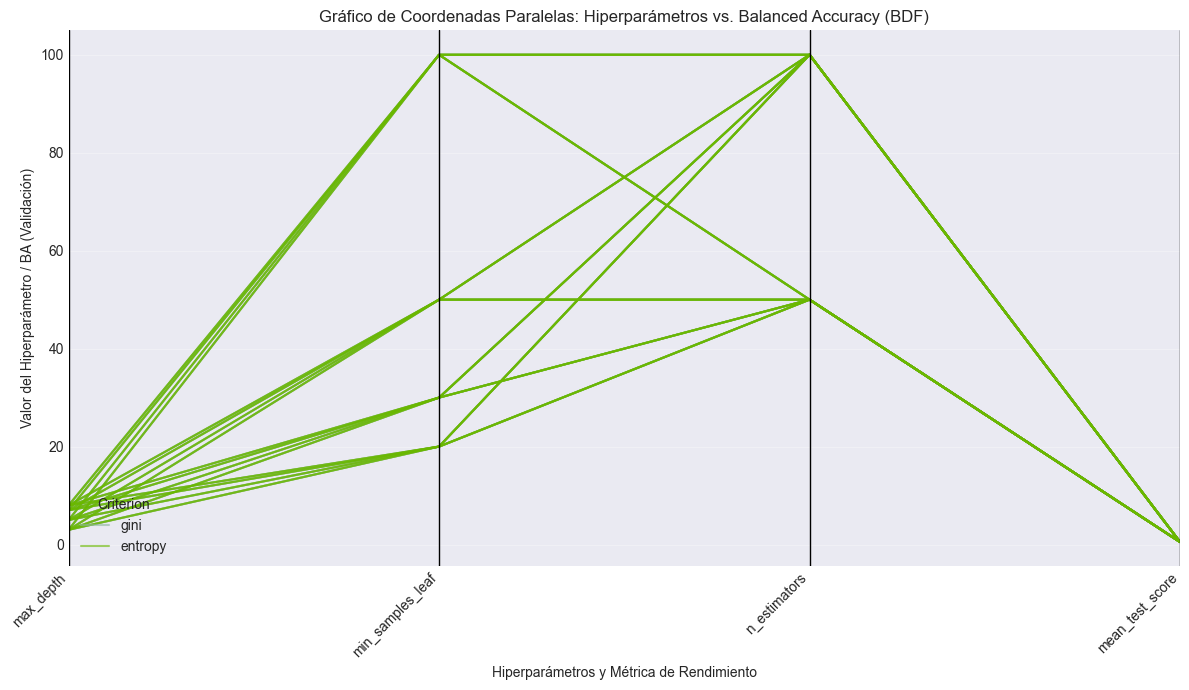

In [16]:
results_params = pd.json_normalize(results_df['params'])

# Crear el DataFrame final con los hiperparámetros y la métrica
plotting_df = results_params.copy()
plotting_df['mean_test_score'] = results_df['mean_test_score']

# --- 2. Generar el Gráfico de Coordenadas Paralelas ---

plt.figure(figsize=(12, 7))

# La columna 'criterion' es la única categórica que usaremos para colorear.
# 'cols' define el orden de los ejes.
parallel_coordinates(
    plotting_df, 
    class_column='criterion', 
    cols=['max_depth', 'min_samples_leaf', 'n_estimators', 'mean_test_score'],
    alpha=0.6,
    linewidth=1.5
)

plt.title('Gráfico de Coordenadas Paralelas: Hiperparámetros vs. Balanced Accuracy (BDF)')
plt.ylabel('Valor del Hiperparámetro / BA (Validación)')
plt.xlabel('Hiperparámetros y Métrica de Rendimiento')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Criterion', loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
print("EJEMPLO DE PREDICCIÓN CON PACIENTES REALES (Balanced Decision Forest)")

n_ejemplos = 5
# 1. Seleccionar los índices aleatorios del conjunto de prueba
# Usamos .index para obtener los índices del DataFrame
indices_aleatorios = np.random.choice(X_test.index, size=n_ejemplos, replace=False)

# 2. Preparar los datos
# BDF NO requiere escalado, por lo que usamos X_test directamente.
pacientes_ejemplo_original = X_test.loc[indices_aleatorios]
realidad = y_test.loc[indices_aleatorios]

print(f"\nAnalizando {n_ejemplos} pacientes del test set...\n")

# 3. Hacer predicciones
# NOTA: Los modelos basados en árboles utilizan las features directamente.
predicciones = mejor_modelo_bf.predict(pacientes_ejemplo_original)
# Las probabilidades son la PROPORCIÓN DE VOTOS de los 100 árboles.
probabilidades = mejor_modelo_bf.predict_proba(pacientes_ejemplo_original) 

# 4. Mapeo de clases (Confirmamos el mapeo para la salida)
clase_nombres = {0: 'No Diabetes', 1: 'Pre-diabetes', 2: 'Diabetes'}

# 5. Mostrar resultados paciente por paciente
for i, idx in enumerate(indices_aleatorios):
    print("="*70)
    print(f"PACIENTE #{idx} (Índice Original)")
    print("="*70)
    
    # Características del paciente
    print("\nCaracterísticas del paciente:")
    print("-"*70)
    # Seleccionamos las primeras 10 columnas para no saturar la salida
    for col_name in X_test.columns[:10]:
        valor = pacientes_ejemplo_original[col_name].iloc[i]
        print(f"   {col_name:25s}: {valor}")
    print(f"   ... (y {len(X_test.columns)-10} características más)")
    
    # Diagnóstico real
    clase_real = int(realidad.iloc[i])
    print(f"\nDIAGNÓSTICO REAL:")
    print(f"   {clase_nombres[clase_real]}")
    
    # Predicción del modelo
    clase_pred = int(predicciones[i])
    print(f"\nPREDICCIÓN DEL MODELO BDF:")
    print(f"   {clase_nombres[clase_pred]}")
    
    # Probabilidades (Proporción de votos de los 100 árboles)
    probs = probabilidades[i]
    print(f"\nCONFIANZA DE LA PREDICCIÓN (Proporción de Árboles):")
    print("-"*70)
    # Mostramos la proporción de votos para cada clase
    for clase_num, prob in enumerate(probs):
        print(f"{clase_nombres[clase_num]:15s}: {prob:6.2%}")
    
    # Resultado
    if clase_pred == clase_real:
        print(f"\nPREDICCIÓN CORRECTA")
    else:
        print(f"\nPREDICCIÓN INCORRECTA")
        print(f"   El modelo predijo '{clase_nombres[clase_pred]}'")
        print(f"   pero el diagnóstico real era '{clase_nombres[clase_real]}'")
    
    print()

# --- RESUMEN FINAL ---
print("RESUMEN DE LOS EJEMPLOS")
# Convertimos la Serie de realidad a un array de NumPy para la comparación
correctas = np.sum(predicciones == realidad.values) 
print(f"\nPredicciones correctas: {correctas}/{n_ejemplos} ({correctas/n_ejemplos:.1%})")
print(f"Predicciones incorrectas: {n_ejemplos-correctas}/{n_ejemplos} ({(n_ejemplos-correctas)/n_ejemplos:.1%})")

EJEMPLO DE PREDICCIÓN CON PACIENTES REALES (Balanced Decision Forest)

Analizando 5 pacientes del test set...

PACIENTE #11386 (Índice Original)

Características del paciente:
----------------------------------------------------------------------
   HighBP                   : 1.0
   HighChol                 : 0.0
   CholCheck                : 1.0
   BMI                      : 25.0
   Smoker                   : 1.0
   Stroke                   : 0.0
   HeartDiseaseorAttack     : 1.0
   PhysActivity             : 0.0
   Fruits                   : 0.0
   Veggies                  : 0.0
   ... (y 11 características más)

DIAGNÓSTICO REAL:
   Diabetes

PREDICCIÓN DEL MODELO BDF:
   Diabetes

CONFIANZA DE LA PREDICCIÓN (Proporción de Árboles):
----------------------------------------------------------------------
No Diabetes    : 16.00%
Pre-diabetes   :  8.00%
Diabetes       : 76.00%

PREDICCIÓN CORRECTA

PACIENTE #28524 (Índice Original)

Características del paciente:
------------------------

In [18]:
resultados =  pd.DataFrame({
    'Modelo': 'Balanced Decision Forest',
    'BA Train': ba_train_bf,
    'BA CV': ba_cv_bf,
    'BA Test': ba_test_bf
}, index=[0])

print(resultados)

resultados.to_csv("../data/data_models/balanced_decision_forest.csv", index=False)
print("Resultados guardados en '.../data/data_models'")

                     Modelo  BA Train   BA CV   BA Test
0  Balanced Decision Forest  0.570369  0.5252  0.470964
Resultados guardados en '.../data/data_models'


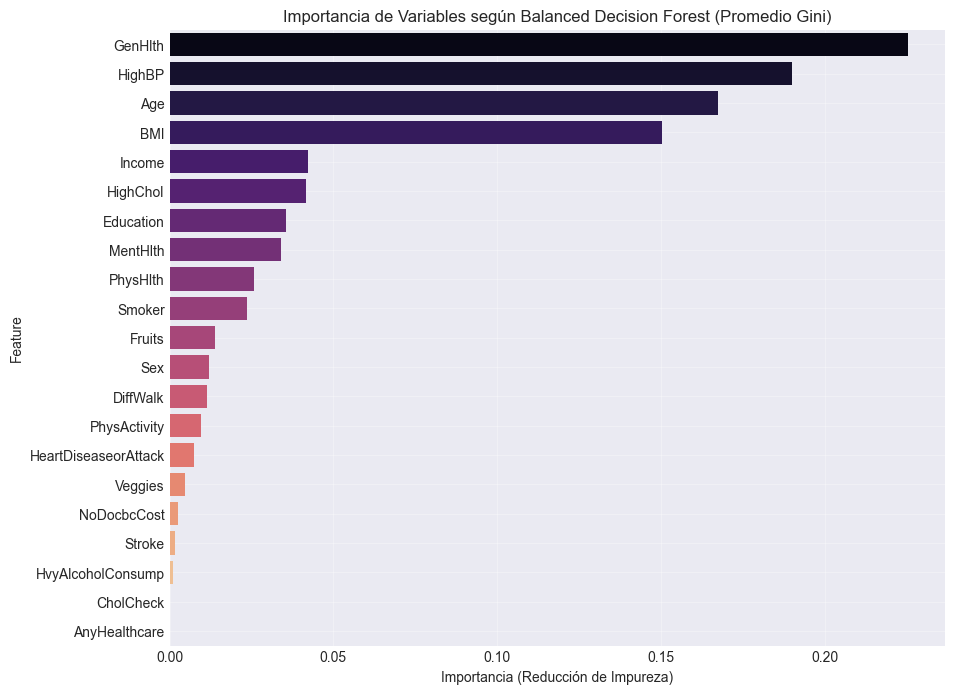

Variables con menor impacto en BDF:
              Feature  Importance
12        NoDocbcCost    0.002498
5              Stroke    0.001545
10  HvyAlcoholConsump    0.000972
2           CholCheck    0.000000
11      AnyHealthcare    0.000000


In [19]:
all_importances = [tree.feature_importances_ for tree in mejor_modelo_bf.models]

# 2. Promediar la importancia
avg_importance_bf = np.mean(all_importances, axis=0)
feature_names = X_train.columns

# 3. Crear DataFrame
df_imp_bf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importance_bf
}).sort_values(by='Importance', ascending=False)

# 4. Visualizar
plt.figure(figsize=(10, 8))
sns.barplot(data=df_imp_bf, x='Importance', y='Feature', palette='magma') # Magma para diferenciar visualmente
plt.title('Importancia de Variables según Balanced Decision Forest (Promedio Gini)')
plt.xlabel('Importancia (Reducción de Impureza)')
plt.grid(True, alpha=0.3)
plt.show()

# 5. Ver candidatas a eliminar
print("Variables con menor impacto en BDF:")
print(df_imp_bf.tail(5))

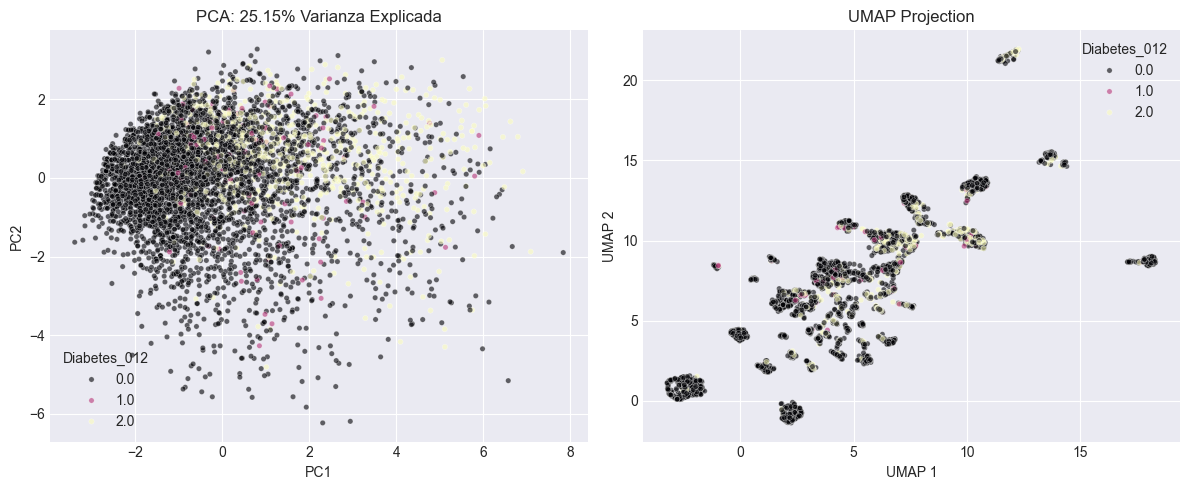

In [20]:
# Usamos una muestra para agilizar
indices = np.random.choice(len(X_train), size=min(5000, len(X_train)), replace=False)
X_sample = X_train.iloc[indices] # Datos originales
y_sample = y_train.iloc[indices]

# ESCALAR (Fundamental para PCA/UMAP, aunque el BDF no lo use)
scaler_viz = StandardScaler()
X_sample_scaled = scaler_viz.fit_transform(X_sample)

# --- A. PCA (Lineal) ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_scaled)

plt.figure(figsize=(12, 5))

# Plot PCA
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_sample, palette='magma', alpha=0.6, s=15)
plt.title(f'PCA: {np.sum(pca.explained_variance_ratio_):.2%} Varianza Explicada')
plt.xlabel('PC1')
plt.ylabel('PC2')

# --- B. UMAP (No Lineal) ---
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_sample_scaled)

# Plot UMAP
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y_sample, palette='magma', alpha=0.6, s=15)
plt.title('UMAP Projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.tight_layout()
plt.show()

In [ ]:
# a. PCA para 95%
pca_full = PCA()
pca_full.fit(X_train_sc)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum >= 0.95) + 1

print(f"\n[PCA] Para explicar el 95% de varianza se necesitan {n_components_95} componentes.")

# b. Transformar
pca_opt = PCA(n_components=n_components_95)
X_train_pca = pca_opt.fit_transform(X_train_sc)
X_test_pca = pca_opt.transform(X_test_sc)

# c. Re-entrenar Balanced Decision Forest
base_tree = DecisionTreeClassifier(**params_bdf, random_state=42)
bdf_pca = BalancedDecisionForest(n_estimators=100, base_estimator=base_tree)

# --- CORRECCIÓN AQUÍ: index=X_train.index ---
X_train_pca_df = pd.DataFrame(X_train_pca, index=X_train.index)
bdf_pca.fit(X_train_pca_df, y_train) 

# d. Evaluar
# --- CORRECCIÓN AQUÍ: index=X_test.index ---
X_test_pca_df = pd.DataFrame(X_test_pca, index=X_test.index)
ba_pca = balanced_accuracy_score(y_test, bdf_pca.predict(X_test_pca_df))

# a. Transformar UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_train_umap = umap_model.fit_transform(X_train_sc)
X_test_umap = umap_model.transform(X_test_sc)

# b. Re-entrenar BDF
base_tree = DecisionTreeClassifier(**params_bdf, random_state=42)
bdf_umap = BalancedDecisionForest(n_estimators=100, base_estimator=base_tree)

# --- CORRECCIÓN AQUÍ: index=X_train.index ---
X_train_umap_df = pd.DataFrame(X_train_umap, index=X_train.index)
bdf_umap.fit(X_train_umap_df, y_train)

# c. Evaluar
# --- CORRECCIÓN AQUÍ: index=X_test.index ---
X_test_umap_df = pd.DataFrame(X_test_umap, index=X_test.index)
ba_umap = balanced_accuracy_score(y_test, bdf_umap.predict(X_test_umap_df))


ba_orig = balanced_accuracy_score(y_test, mejor_modelo_bf.predict(X_test))

# Calcular porcentajes
red_pca = (1 - n_components_95 / n_features_orig) * 100
red_umap = (1 - 2 / n_features_orig) * 100

results_data = {
    'Método': ['Original', f'PCA ({n_components_95} Comps)', 'UMAP (2 Comps)'],
    'N_Features': [n_features_orig, n_components_95, 2],
    '% Reducción': [0.0, red_pca, red_umap],
    'Balanced Accuracy': [ba_orig, ba_pca, ba_umap]
}

df_results_bdf = pd.DataFrame(results_data)
display(df_results_bdf)


[PCA] Para explicar el 95% de varianza se necesitan 19 componentes.

[UMAP] Reduciendo a 2 dimensiones...

--- RESULTADOS DE REDUCCIÓN DE DIMENSIONALIDAD (Balanced DF) ---


,Método,N_Features,% Reducción,Balanced Accuracy
0,Original,21,0.00000,0.470964
1,PCA (19 Comps),19,9.52381,0.490728
2,UMAP (2 Comps),2,90.47619,0.459557
